# Logistic Regression

## Load Packages and Prep Data

In [1]:
# import standard packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix

In [2]:
LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

In [3]:
# load data
train_data = pd.read_csv('data/train_data_fe.csv')
test_data = pd.read_csv('data/test_data_fe.csv')
print(train_data.shape)
print(test_data.shape)

(62889, 47)
(15723, 47)


In [4]:
# drop unneeded columns
train_data.drop(['stone_soil', 'id', 'img_id'], axis=1, inplace = True)
test_data.drop(['stone_soil', 'id', 'img_id'], axis=1, inplace = True)

In [5]:
# prep data
y_train = train_data['stone_soil_enc']
X_train = train_data.drop(['stone_soil_enc'], axis=1)
y_test = test_data['stone_soil_enc']
X_test = test_data.drop(['stone_soil_enc'], axis=1)

In [6]:
# define a function for scoring
def pred_metrics(real, pred) -> None:
    print("Accuracy:\t{}".format(accuracy_score(real, pred)))
    print("Precision:\t{}".format(precision_score(real, pred)))
    print("Recall:\t\t{}".format(recall_score(real, pred)))
    print("F1:\t\t{}".format(f1_score(real, pred)))

## Model 0
- Defaults

### Fit Model

In [7]:
# fit logistic regression model
log_0 = LogisticRegression(max_iter=200)
x = log_0.fit(X_train, y_train)

### Cross validation

In [8]:
# cross validation
# low f1 score indicates low precision and low recall
score = cross_val_score(log_0, X_train, y_train, scoring = "f1")
print(score.round(decimals=4))
print(score.mean().round(decimals=4))

[0.5198 0.5028 0.4952 0.4939 0.4959]
0.5015


## Model 1
- Regularize by selecting important features from recursive feature elimination ranking

### Feature Selection

In [9]:
# recursive feature elimination to determine feature importance
log = LogisticRegression(max_iter = 400)
model_rfe = RFECV(log, cv = 5)
x = model_rfe.fit(X_train, y_train)

In [10]:
# feature ranking
rfe = model_rfe.ranking_
features = X_train.columns
rfe_df = pd.DataFrame({'features': features, 'rfe_rank': rfe})
rfe_df.sort_values(by = 'rfe_rank', ascending = True)

,features,rfe_rank
21,concavity,1
37,fiber_width,1
36,fiber_length,1
35,ellipticity,1
34,angularity,1
31,t_w_ratio,1
30,w_t_ratio,1
28,l_w_ratio,1
26,curvature,1
25,transparency,1


In [11]:
# features ranked 1 are the most important
# select only the more important features as a means of regularization
selected_features = rfe_df[rfe_df['rfe_rank'] == 1]['features'].values
X_train_new = X_train[selected_features]
X_test_new = X_test[selected_features]

In [12]:
# 16 important features
X_train_new.shape

(62889, 16)

### Fit Model

In [13]:
# fit logistic regression model
# using max_iter 400 to avoid error message
# using X_train_new to select only the 16 features that were selected
log_1 = LogisticRegression(max_iter = 400)
x = log_1.fit(X_train_new, y_train)

### Cross validation

In [14]:
# cross validation
# low f1 score indicates low precision and low recall
score = cross_val_score(log_1, X_train, y_train, scoring = "f1")
print(score.round(decimals=4))
print(score.mean().round(decimals=4))

[0.5198 0.5028 0.4952 0.4939 0.4959]
0.5015


## Model 2
- Adjust hyperparameters

### Fit Model

In [15]:
# tried a variety of different combinations of parameters
# same selected features as the original model
log_2 = LogisticRegression(max_iter = 600, penalty="l1", tol=0.001, solver="saga")
x = log_2.fit(X_train_new, y_train)

### Cross-Validation
- Slight improvement

In [16]:
# cross validation
# low f1 score indicates low precision and low recall
score = cross_val_score(log_2, X_train, y_train, scoring = "f1")
print(score.round(decimals=4))
print(score.mean().round(decimals=4))

[0.5588 0.5344 0.5327 0.5215 0.535 ]
0.5365


## Test Performance
Final test performance of model chosen using best cross-validation scores. These scores will be used to select amongst different model types.

In [23]:
# test the performance of the selected model
y_pred = log_2.predict(X_test_new)
pred_metrics(y_test,y_pred)

Accuracy:	0.9452394581186796
Precision:	0.82
Recall:		0.2645161290322581
F1:		0.4


<AxesSubplot:>

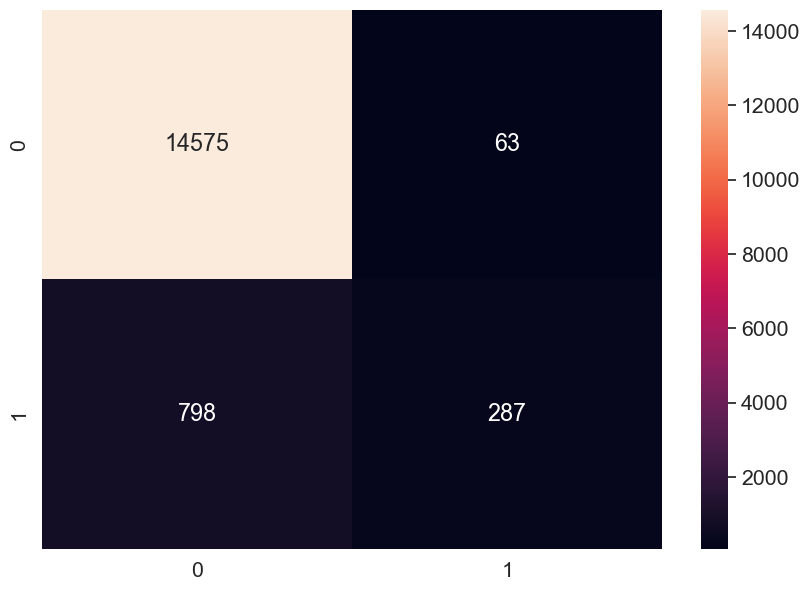

In [24]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')